# Hierarchical agglomerative clustering (Above-phoneme)

Import libraries and helpers

In [1]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from lib.esn import ESN
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

#### Data
Collect the TIMIT training dataset. The data are pre-processed into 10 steps long 14-mffc signals with 39 phoneme labels/classes.

In [2]:
path = '../../data/'
fc = DataLoader(path)

dr = []
speakers = []
XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features, labels, _ = fc.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


Regroup data and label arrays into a phoneme-keyed dictionary. All phonemes are used, but for debugging a subset may be selected.

In [3]:
from dataset.data_processing import *

selected_labels = None # No filtering is applied
#selected_labels = ["aa", "b", "s", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh", "er", "ey", "ix", "aw", "axr", "l", "oy", "r", "y"]

phonemes, features, labels = filter_data(features, labels, selected_labels=selected_labels, limit=None)
group = group_by_labels(features, labels)

Filtered to 177080 samples of shape (10, 14)


### Clustering experiment

### 1. Compute conceptors, one per phoneme
The ESN parameters were chosen by hand.

In [ ]:
# Init reservoir
esn_params = {
    "in_dim": n_mels,
    "out_dim": n_mels,
    "N": 100,
    "W_in_scale": 1.1,
    "b_scale": .6,
    "spectral_radius": 2.57,
    "weights": .1
}

esn = ESN(esn_params)

# Compute conceptors
from experiments.helpers.experiment_helpers import *

aperture = "auto"
normalize = True
Cs = compute_Cs(group=group, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ, cache=True)

KeyboardInterrupt: 

#### 2. Compute heatmap
Compute the mutual similarities between every two phoneme conceptors.

In [5]:
from lib.clustering.clustering_metrics import *

save = True
hm = None
hm_filename = str(selected_labels)+path_option+XorZ + str(aperture) + str(esn.esn_params) + str(len(group.keys())) + str(len(list(group.values())[0])) + "heatmap"

if save:
    hm = try_reading_from_cache(hm_filename)
if hm is None:
    print("- computing heatmap")
    hm = get_heat_map(Cs, similarity_c)
    save_to_cache(hm_filename, hm)
    print("--- Done")

- loading from file
--- Done


#### 3. Perform average linkage of phoneme conceptors and plot results
Therefore, the similarities in the heat map are converted to distances.

In [22]:
import scipy.cluster.hierarchy as sc
import scipy.spatial.distance as ssd

distArray = ssd.squareform(hm)
distArray = 1-distArray
link = sc.linkage(distArray, method='average', optimal_ordering=False)

#### 4. Plotting
Plot the resulting dendrogram

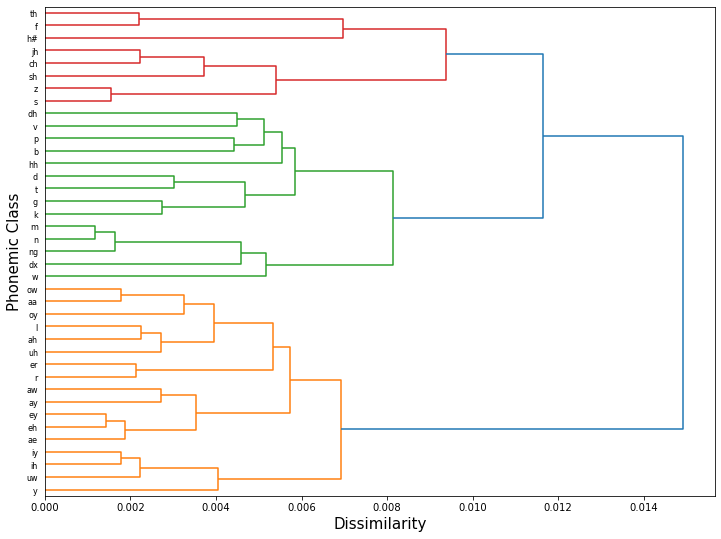

In [31]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.grid(False)
ax.set_facecolor('white')
D = sc.dendrogram(link,labels=phonemes,orientation='right',distance_sort=False)

plt.ylabel('Phonemic Class',fontsize=15)
plt.xlabel(r"Dissimilarity",fontsize=15)
plt.show()

Plot the similarity heatmap on which basis the distances were computed that were used for clustering. The marked groups are, from top-left to bottom-right, vowels, mixed, nasals, affricatives, and stops

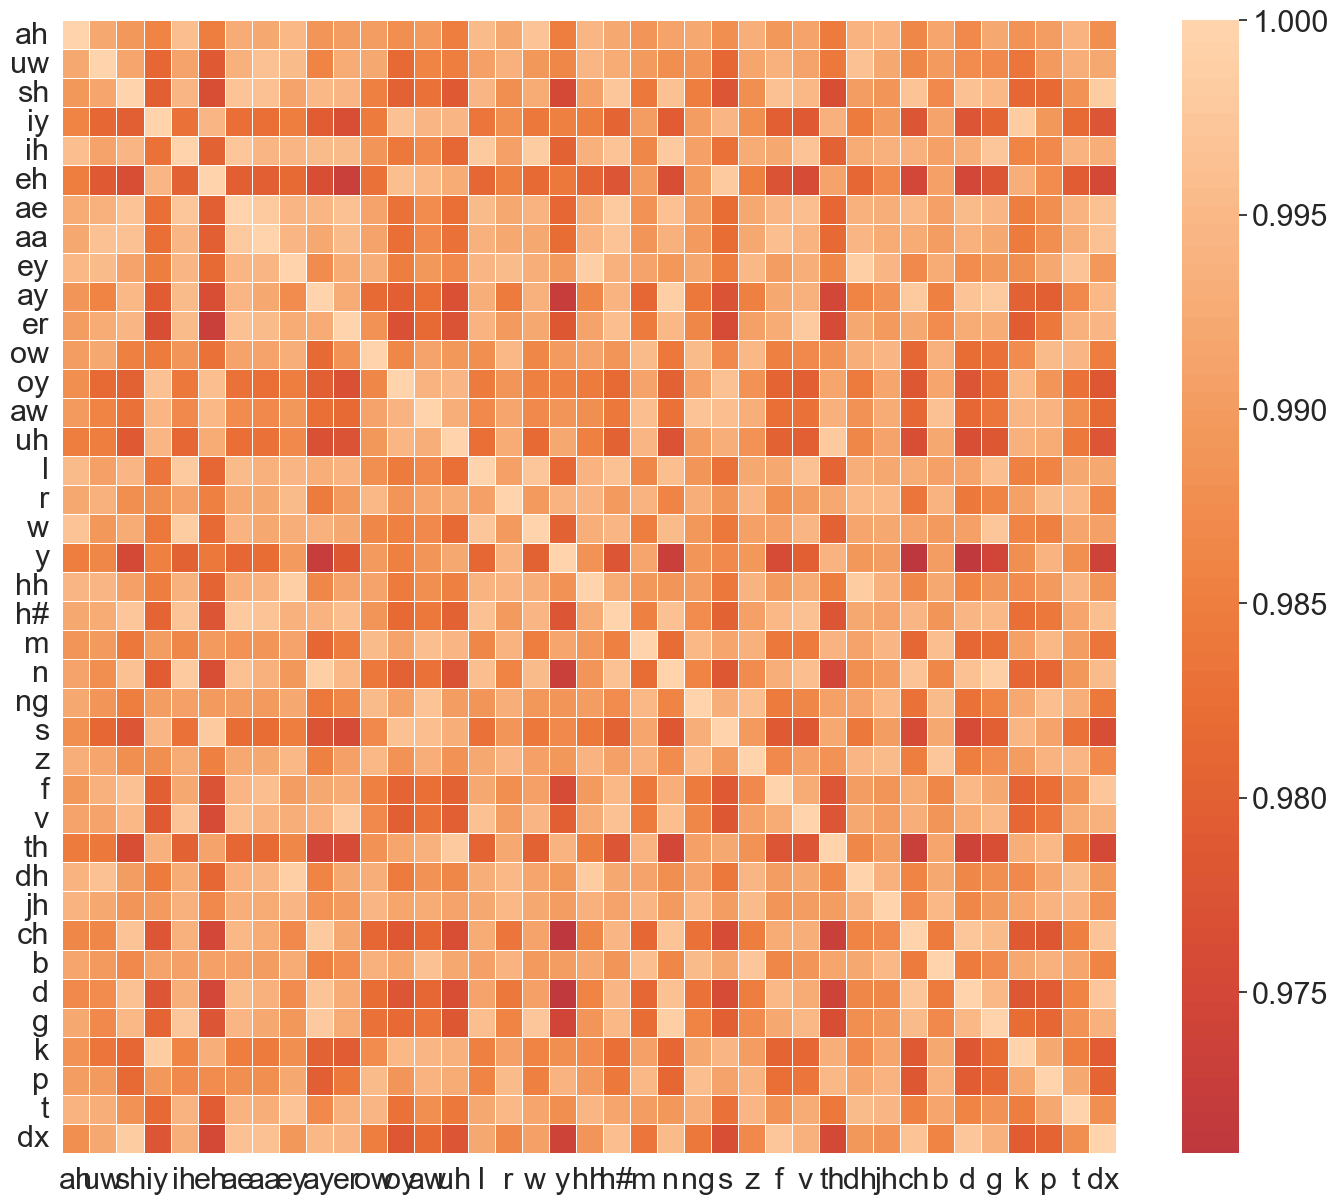

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

np.fill_diagonal(hm, 1)

labs = D["ivl"]
custom_labs = ['ah', 'uw', 'sh', 'iy', 'ih', 'eh', 'ae', 'aa', 'ey', 'ay', 'er', 'ow', 'oy', 'aw', 'uh',
               'l', 'r', 'w', 'y', 'hh', 'h#',
               'm', 'n', 'ng',
               's', 'z', 'f', 'v', 'th', 'dh',
               'jh', 'ch',
               'b', 'd', 'g', 'k', 'p', 't', 'dx']

reorder = [ labs.index(lab) for lab in custom_labs]
hm = hm[reorder,:]
hm = hm[:,reorder]

plt.figure(figsize=(17,15),dpi=100)
sns.set_theme()
sns.set(font_scale=2)

ax_hm = sns.heatmap(hm, xticklabels=custom_labs, yticklabels=custom_labs, linewidths=.5, center=np.mean(hm)-.05)
plt.rc('xtick', labelsize='20')    # fontsize of the tick labels
plt.rc('ytick', labelsize='20')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# # Adding coloring to phonetic groups
# recs = [
#     [0,15],
#     [15,6],
#     [21,3],
#     [24,6],
#     [30,2],
#     [32,7]
# ]
# for rec in recs:
#     ax_hm.add_patch(
#          patches.Rectangle(
#              (rec[0], rec[0]),
#              rec[1], rec[1],
#              edgecolor='blue',
#              fill=False,
#              lw=4
#          )
#     )

plt.show()